# Position Encoding
In this exercise, we will look at position encoding for the Transformer architecture.

In [7]:
import torch
import torch.nn as nn

## Creating an Embedding
Consider the following vocabulary:

In [8]:
vocab = ["dog", "cat", "fox", "walks", "jumps", "sleeps", "and", "the", ".", ","]
print(f"Vocab size: {len(vocab)}")

Vocab size: 10


Take a look at the [nn.Embedding documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html). Create an embedding with a vocabulary size of 10 and an embedding dimension of 6.

In [9]:
emb_dim = 6
embedding = nn.Embedding(len(vocab), emb_dim)

Embed the sentence: "the dog sleeps , the cat walks and the fox jumps ."

In [10]:
sentence = "the dog sleeps , the cat walks and the fox jumps ."
words = sentence.split()
emb = embedding(torch.tensor([vocab.index(word) for word in words]))
print(emb.shape)
print(emb)

torch.Size([12, 6])
tensor([[ 2.1837, -0.5405,  0.7866, -0.2801, -0.7448, -1.3808],
        [ 0.0986, -0.0758, -0.6683,  0.5985,  0.2635, -0.5573],
        [ 0.5289,  0.3140, -2.1749,  0.6387,  2.5804,  0.0953],
        [ 1.6947, -1.1849,  0.2363,  1.6649,  0.4188,  0.8455],
        [ 2.1837, -0.5405,  0.7866, -0.2801, -0.7448, -1.3808],
        [-0.7263, -0.3549, -0.3200,  0.1708,  0.3025, -0.4037],
        [-0.4135,  0.2972, -0.4618, -0.8173, -0.7566,  0.5932],
        [-0.4484,  1.0700,  0.9739,  0.2818, -0.7239,  1.4978],
        [ 2.1837, -0.5405,  0.7866, -0.2801, -0.7448, -1.3808],
        [ 0.6878,  2.4579,  1.1598, -0.7464, -0.8793, -0.5160],
        [-0.8942,  1.6940, -0.0338, -1.2394,  0.3368,  0.4561],
        [-0.4564,  1.0889,  2.8008, -0.1314, -0.1678,  0.7002]],
       grad_fn=<EmbeddingBackward0>)


## Absolute Position Encoding
The functions for absolute position encoding, as defined in [the Transformer paper](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) are as follows:

$$
\begin{align}
pos_{i, 2j} &= \sin(i / 10000^{2j/d}) \\
pos_{i, 2j+1} &= \cos(i / 10000^{2j/d})
\end{align}
$$
where $i$ is the absolute position in the sequence, and $j$ is the dimension of the embedding vector.

Create a function `absolute_position_encoding` that takes the position in the sequence $i$ and the dimension $d$ as an input and returns the position vector.

In [11]:
def absolute_position_encoding(position, dim):
    assert dim % 2 == 0, "Cannot create sin/cos encoding for odd dimensions"
    encoding = torch.ones(dim)
    encoding.requires_grad = False
    """
    for j in range(0, dim, 2):
        part = position/(10000**(2*j/dim))
        encoding[j] = torch.sin(part)
        encoding[j+1] = torch.cos(part)
    """
    encoding *= position
    dim_vec = torch.arange(0, dim, 2) / dim  # 2j/d
    dim_vec = 10000**dim_vec
    encoding[0::2] = torch.sin(encoding[0::2] / dim_vec)
    encoding[1::2] = torch.cos(encoding[1::2] / dim_vec)
    return encoding

Run the command below to see the values for the position vectors of the first 100 positions and the first 5 dimensions.

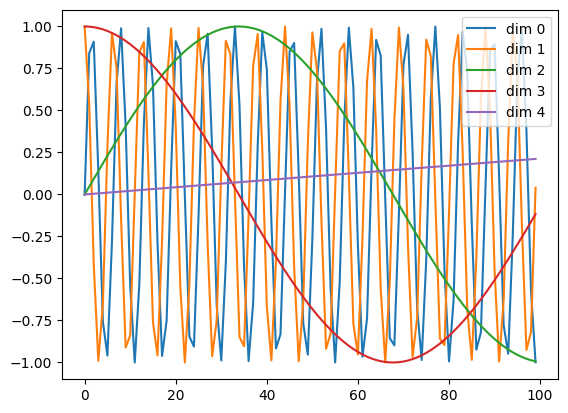

In [12]:
import matplotlib.pyplot as plt

plt.figure()
x = list(range(100))
pos_vectors = [absolute_position_encoding(i, emb_dim) for i in x]
for dim in range(5):
    y = [pv[dim].item() for pv in pos_vectors]
    plt.plot(x, y, label=f"dim {dim}")
plt.legend()
plt.show()

Apply the position encoding to the embeddings from earlier.

In [16]:
pos_emb = torch.stack(
    [absolute_position_encoding(i, emb_dim) for i in range(emb.shape[0])], dim=0
)
print(pos_emb.shape)
print(pos_emb)
x = emb + pos_emb

torch.Size([12, 6])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998],
        [-0.5440, -0.8391,  0.4477,  0.8942,  0.0215,  0.9998],
        [-1.0000,  0.0044,  0.4887,  0.8725,  0.0237,  0.9997]])


## Absolute Position Embedding
Write a class `AbsolutePositionEmbedding` that is initialized with a maximum length and an embedding dimension. In its `forward` method, it should take an input tensor (of shape `[batch_size, sequence_length, embedding_dim]`) and add the position embeddings to the input tensor.

In [19]:
class AbsolutePositionEmbedding(nn.Module):

    def __init__(self, embedding_dim, max_length=512):
        super().__init__()
        self.max_length = max_length
        self.embedding = nn.Embedding(self.max_length, embedding_dim)

    def forward(self, x):
        batch_size, seq_len, embedding_dim = x.shape
        positions = torch.arange(seq_len)
        return x + self.embedding(positions).unsqueeze(0)

Try your class with an example.

In [20]:
absolute_position_embedding = AbsolutePositionEmbedding(20, 512)
x1 = torch.randn(5, 12, 20)
x = absolute_position_embedding(x1)
print(x.shape)

torch.Size([5, 12, 20])


## Relative Position Embedding
Create a class `RelativePositionEmbedding` that is initialized with a maximum relative distance and an embedding dimension. Its `forward` method should take an input tensor of size `[batch_size, hidden_dim]` and apply the relative position embeddings given the positions $i$ of the query and $j$ of the key.

In [27]:
class RelativePositionEmbedding(nn.Module):

    def __init__(self, embedding_dim, max_dist=16):
        super().__init__()
        self.max_dist = max_dist
        self.embedding = nn.Embedding(2 * max_dist + 1, embedding_dim)

    def forward(self, x, i, j):
        pos = i - j + self.max_dist
        pos = max(0, min(2 * self.max_dist, pos))
        return x + self.embedding(torch.tensor(pos)).unsqueeze(0)

Try it with an example.

In [28]:
rel_pos_emb = RelativePositionEmbedding(20, 16)
x = torch.randn(5, 20)
result = rel_pos_emb(x, 0, 3)
result = rel_pos_emb(x, 49, 15)
print(result.shape)

torch.Size([5, 20])


**Question:** Where would we use this module?

**Answer:** 

**Question:** Look at the HuggingFace implementation of relative position embeddings in the BERT model:
- [initialization from line 244](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/bert/modeling_bert.py#L244)
- [forward method from line 320](https://github.com/huggingface/transformers/blob/v4.46.0/src/transformers/models/bert/modeling_bert.py#L320)

Describe what their `relative_key` method does differently from the [Shaw et al. (2018)](https://aclanthology.org/N18-2074/) paper we saw in the lecture.

**Answer:**